In [90]:
import pandas as pd
import numpy as np


In [91]:
from typing import cast
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import (
    ClimateDataDTO,
    FutureClimateDataDTO,
    LocationDTO,
)
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )

In [92]:
location = cast(LocationDTO, location)

await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model = (
    await climate_generative_model_repository.create_model_for_location(location.id)
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8679 - root_mean_squared_error: 0.9306 - val_loss: 0.2792 - val_root_mean_squared_error: 0.5284
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2956 - root_mean_squared_error: 0.5433 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758 - val_loss: 0.1540 - val_root_mean_squared_error: 0.3924
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2052 - root_mean_squared_error: 0.4528 - val_loss: 0.1454 - val_root_mean_squared_error: 0.3814
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.1402 - val_root_mean_squared_error: 0.3744
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2075 - root_mean_squared_error: 0.4554 - val_loss: 0.1383 - val_root_mean_squared_error: 0.3719
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.197

In [93]:
from tesi.zappai.repositories.climate_generative_model_repository import (
    ClimateGenerativeModelRepository,
    FEATURES_WITH_SIN_COS,
    TARGET,
    MODEL_CMIP5_VARIABLES_WITH_SIN_COS,
    SEQ_LENGTH,
    add_sin_cos_year
)


df_test = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(
        location_id=location.id,
        year_from=climate_generative_model.test_start_year,
        month_from=climate_generative_model.test_start_month,
        year_to=climate_generative_model.test_end_year,
        month_to=climate_generative_model.test_end_month,
    )
)

df_test = add_sin_cos_year(df_test)

In [94]:
x_df_test = df_test[FEATURES_WITH_SIN_COS]
x_df_test

surface_solar_radiation_downwards  \
year month                                      
2011 10                          1.192052e+07   
     11                          7.867499e+06   
     12                          6.771313e+06   
2012 1                           8.295657e+06   
     2                           8.984526e+06   
...                                       ...   
2024 2                           1.103211e+07   
     3                           1.623242e+07   
     4                           2.111158e+07   
     5                           2.225734e+07   
     6                           2.702775e+07   

            surface_thermal_radiation_downwards  surface_net_solar_radiation  \
year month                                                                     
2011 10                            2.856999e+07                 1.067037e+07   
     11                            2.756182e+07                 7.057508e+06   
     12                            2.541200e+07                 6.069447e+06   
2012 1                             2.357119e+07                 7.405434e+06   
     2                             2.516410e+07                 7.888859e+06   
...                                         ...                          ...   
2024 2                             2.576133e+07                 9.841429e+06   
     3                             2.616479e+07                 1.449971e+07   
     4                             2.717887e+07                 1.886191e+07   
     5                             2.969656e+07                 1.992405e+07   
     6                             3.171924e+07                 2.423653e+07   

            surface_net_thermal_radiation  total_cloud_cover  \
year month                                                     
2011 10                     -6.596848e+06           0.427252   
     11                     -5.707553e+06           0.526097   
     12                     -6.428651e+06           0.434871   
2012 1                      -7.192958e+06           0.368344   
     2                      -5.439420e+06           0.630574   
...                                   ...                ...   
2024 2                      -6.344076e+06           0.466573   
     3                      -6.661283e+06           0.478982   
     4                      -7.231584e+06           0.405940   
     5                      -6.320944e+06           0.516750   
     6                      -7.692243e+06           0.239848   

            2m_dewpoint_temperature  soil_temperature_level_3  \
year month                                                      
2011 10                  284.729434                293.741419   
     11                  283.043408                289.806455   
     12                  279.451805                286.558917   
2012 1                   275.281463                283.667371   
     2                   275.892448                282.454511   
...                             ...                       ...   
2024 2                   281.087708                285.261142   
     3                   282.018877                286.256922   
     4                   283.168098                288.858824   
     5                   287.139088                291.249895   
     6                   290.095587                296.350498   

            volumetric_soil_water_layer_3      sin_year      cos_year  \
year month                                                              
2011 10                          0.152529 -8.660254e-01  5.000000e-01   
     11                          0.162347 -5.000000e-01  8.660254e-01   
     12                          0.191056 -2.449294e-16  1.000000e+00   
2012 1                           0.203387  5.000000e-01  8.660254e-01   
     2                           0.240692  8.660254e-01  5.000000e-01   
...                                   ...           ...           ...   
2024 2                           0.178380  8.660254e-01  5.000000e-01 

In [95]:
y_df_test = df_test[TARGET]
y_df_test

surface_solar_radiation_downwards  \
year month                                      
2011 10                          1.192052e+07   
     11                          7.867499e+06   
     12                          6.771313e+06   
2012 1                           8.295657e+06   
     2                           8.984526e+06   
...                                       ...   
2024 2                           1.103211e+07   
     3                           1.623242e+07   
     4                           2.111158e+07   
     5                           2.225734e+07   
     6                           2.702775e+07   

            surface_thermal_radiation_downwards  surface_net_solar_radiation  \
year month                                                                     
2011 10                            2.856999e+07                 1.067037e+07   
     11                            2.756182e+07                 7.057508e+06   
     12                            2.541200e+07                 6.069447e+06   
2012 1                             2.357119e+07                 7.405434e+06   
     2                             2.516410e+07                 7.888859e+06   
...                                         ...                          ...   
2024 2                             2.576133e+07                 9.841429e+06   
     3                             2.616479e+07                 1.449971e+07   
     4                             2.717887e+07                 1.886191e+07   
     5                             2.969656e+07                 1.992405e+07   
     6                             3.171924e+07                 2.423653e+07   

            surface_net_thermal_radiation  total_cloud_cover  \
year month                                                     
2011 10                     -6.596848e+06           0.427252   
     11                     -5.707553e+06           0.526097   
     12                     -6.428651e+06           0.434871   
2012 1                      -7.192958e+06           0.368344   
     2                      -5.439420e+06           0.630574   
...                                   ...                ...   
2024 2                      -6.344076e+06           0.466573   
     3                      -6.661283e+06           0.478982   
     4                      -7.231584e+06           0.405940   
     5                      -6.320944e+06           0.516750   
     6                      -7.692243e+06           0.239848   

            2m_dewpoint_temperature  soil_temperature_level_3  \
year month                                                      
2011 10                  284.729434                293.741419   
     11                  283.043408                289.806455   
     12                  279.451805                286.558917   
2012 1                   275.281463                283.667371   
     2                   275.892448                282.454511   
...                             ...                       ...   
2024 2                   281.087708                285.261142   
     3                   282.018877                286.256922   
     4                   283.168098                288.858824   
     5                   287.139088                291.249895   
     6                   290.095587                296.350498   

            volumetric_soil_water_layer_3  
year month                                 
2011 10                          0.152529  
     11                          0.162347  
     12                          0.191056  
2012 1                           0.203387  
     2                           0.240692  
...                                   ...  
2024 2                           0.178380  
     3                           0.196695  
     4                           0.190879  
     5                           0.173759  
     6                           0.162444  

[153 rows x 8 columns]

Index(['surface_solar_radiation_downwards',
       'surface_thermal_radiation_downwards', 'surface_net_solar_radiation',
       'surface_net_thermal_radiation', 'total_cloud_cover',
       '2m_dewpoint_temperature', 'soil_temperature_level_3',
       'volumetric_soil_water_layer_3'],
      dtype='object')
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


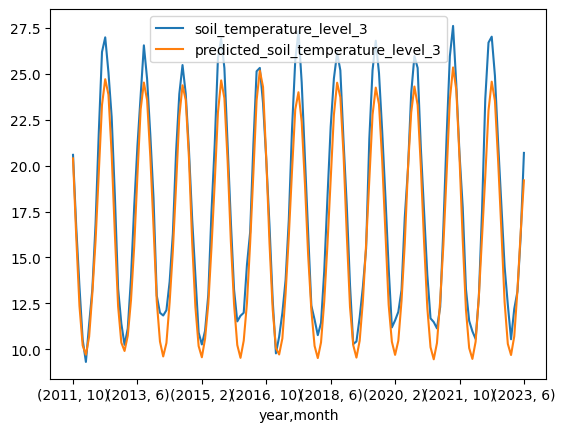

In [96]:
if len(TARGET) > 0:
    from typing import cast

    from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository

    print(y_df_test.columns)

    x_test_scaled = cast(np.ndarray, x_scaler.transform(x_df_test.to_numpy()))
    y_test_scaled = cast(np.ndarray, y_scaler.transform(y_df_test.to_numpy()))

    x_test_formatted, y_test_formatted = ClimateGenerativeModelRepository.format_data(x=x_test_scaled, y=y_test_scaled)

    predictions = model.predict(x_test_formatted)
    inverse_scaled_predictions = cast(np.ndarray, y_scaler.inverse_transform(predictions))
    predictions_df = pd.DataFrame(data=inverse_scaled_predictions, columns=TARGET)
    y_df_plot = y_df_test[:-SEQ_LENGTH].copy().reset_index()
    for target in TARGET:
        y_df_plot[f"predicted_{target}"] = predictions_df[target]
    y_df_plot = y_df_plot.set_index(keys=["year", "month"], drop=True)

    if "soil_temperature_level_3" in TARGET:
        y_df_plot["soil_temperature_level_3"] = y_df_plot["soil_temperature_level_3"] - 273.15
        y_df_plot["predicted_soil_temperature_level_3"] = y_df_plot["predicted_soil_temperature_level_3"] - 273.15
        y_df_plot[["soil_temperature_level_3", "predicted_soil_temperature_level_3"]].plot()

lon, lat: (16.25, 39.43820224719101)
year_from, month_from: (1970, 1)
year_to, month_to: (9999, 12)


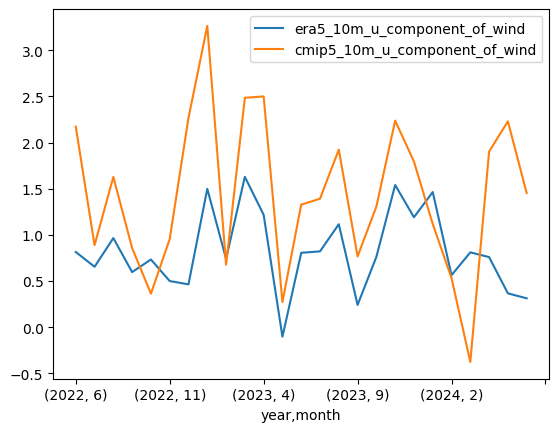

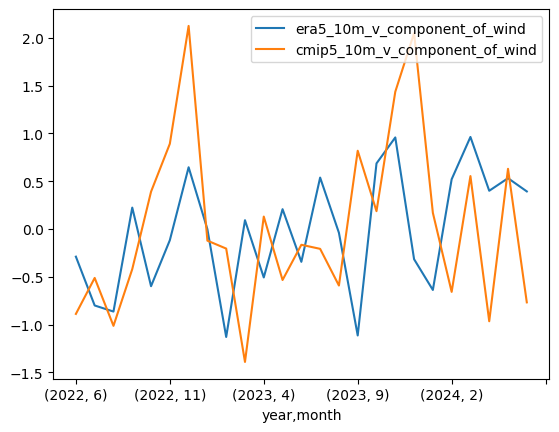

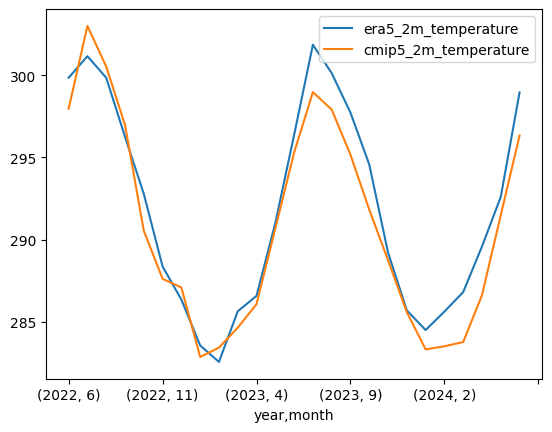

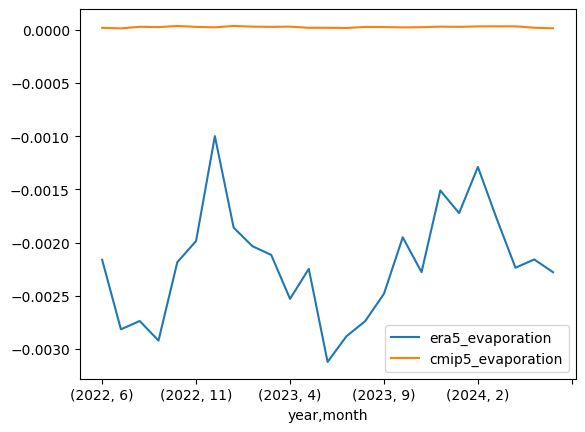

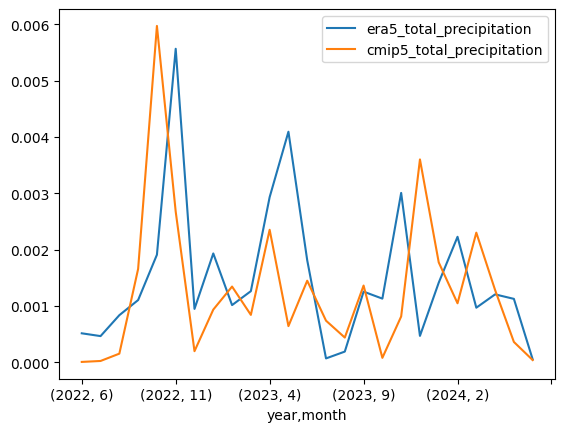

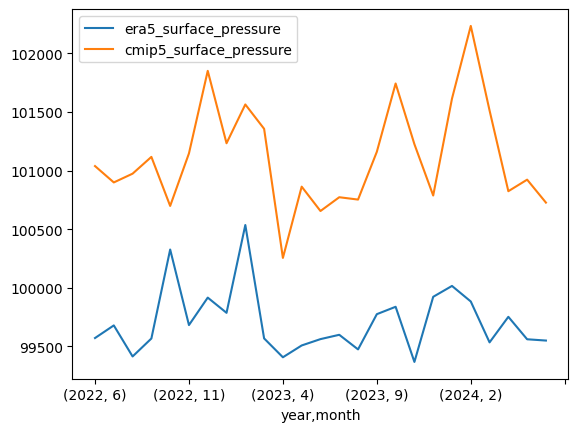

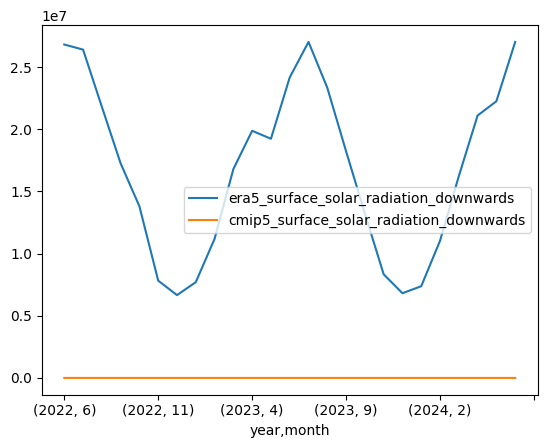

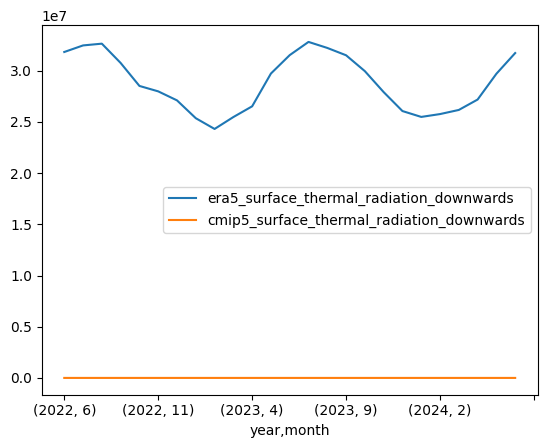

In [97]:
# Graph the data from CMIP5 and from ERA5 to confront them, so we can establish which CMIP5 data are actually accurate
from tesi.zappai.repositories.copernicus_data_store_api import (
    ERA5_VARIABLES,
    CMIP5_VARIABLES,
)

MONTHS_BEFORE = 25


true_data_df = df_test[-MONTHS_BEFORE:].copy()

# PLOT DATA
from matplotlib import pyplot as plt


entire_future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        year_from=1970,
        month_from=1,
        year_to=9999,
        month_to=12
    )
)

entire_future_climate_data_df = entire_future_climate_data_df[CMIP5_VARIABLES]
true_data_df = true_data_df[ERA5_VARIABLES]

for variable in CMIP5_VARIABLES:
    true_data_df[f"cmip5_{variable}"] = entire_future_climate_data_df[
        variable
    ]

for variable in ERA5_VARIABLES:
    true_data_df = true_data_df.rename(
        columns={variable: f"era5_{variable}"}
    )

# removes the future climate data that is too much into the past or too much into the future
true_data_df = true_data_df.dropna()

cmip5_kelvin_to_celsius = ["2m_temperature"]

for temperature in cmip5_kelvin_to_celsius:
    if temperature in true_data_df.columns:
        true_data_df[temperature] = true_data_df[temperature] - 273.15
        true_data_df[f"cmip5_{temperature}"] = (
            true_data_df[f"cmip5_{temperature}"] - 273.15
        )

for variable in CMIP5_VARIABLES:
    true_data_df[[f"era5_{variable}", f"cmip5_{variable}"]].plot()

start_year: 2022
start_month: 6
lon, lat: (16.25, 39.43820224719101)
year_from, month_from: (2022, 6)
year_to, month_to: (2024, 6)
MultiIndex([(2022,  6),
            (2022,  7),
            (2022,  8),
            (2022,  9),
            (2022, 10),
            (2022, 11),
            (2022, 12),
            (2023,  1),
            (2023,  2),
            (2023,  3),
            (2023,  4),
            (2023,  5),
            (2023,  6),
            (2023,  7),
            (2023,  8),
            (2023,  9),
            (2023, 10),
            (2023, 11),
            (2023, 12),
            (2024,  1),
            (2024,  2),
            (2024,  3),
            (2024,  4),
            (2024,  5),
            (2024,  6)],
           names=['year', 'month'])
MultiIndex([(2022,  6),
            (2022,  7),
            (2022,  8),
            (2022,  9),
            (2022, 10),
            (2022, 11),
            (2022, 12),
            (2023,  1),
            (2023,  2),
            (202

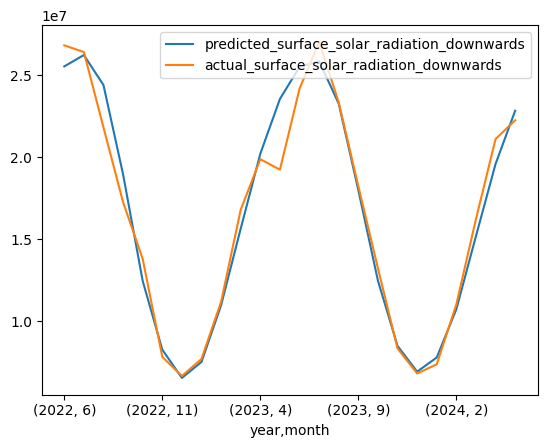

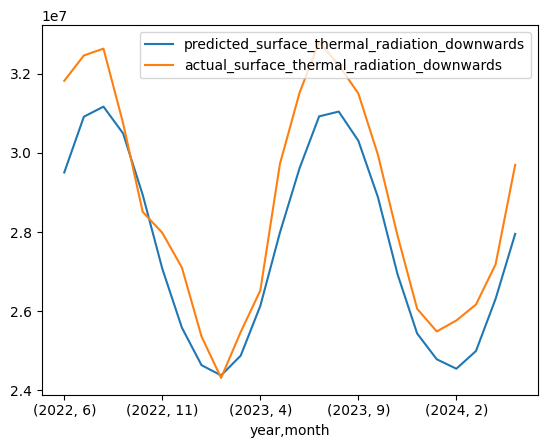

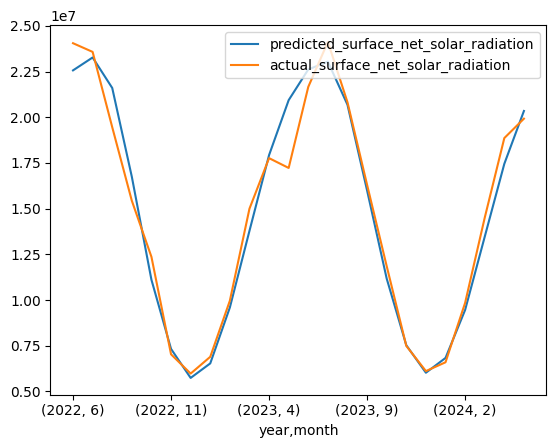

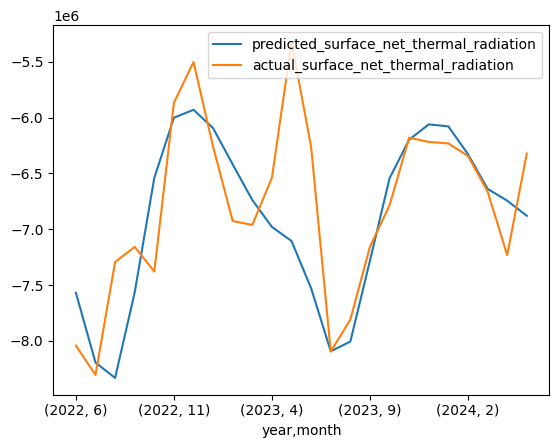

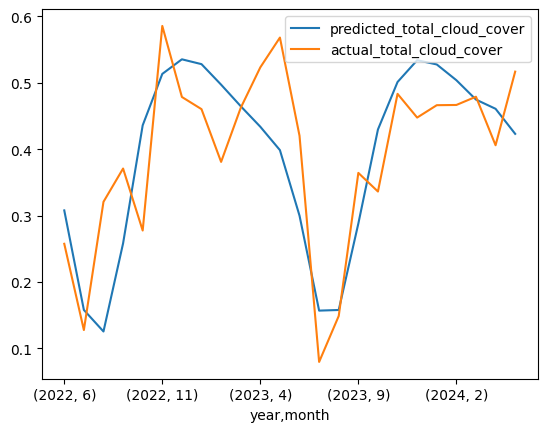

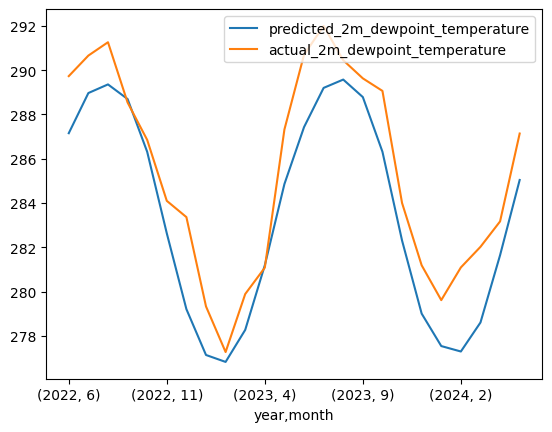

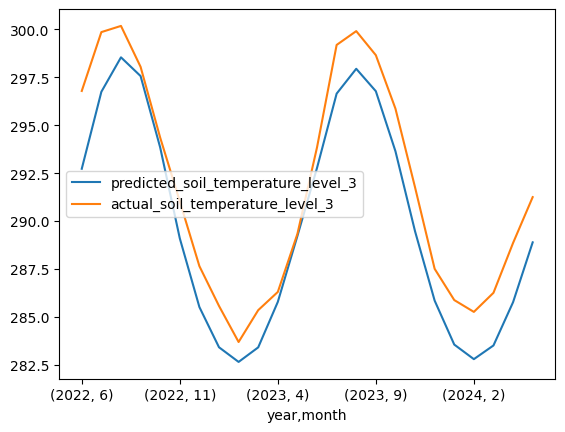

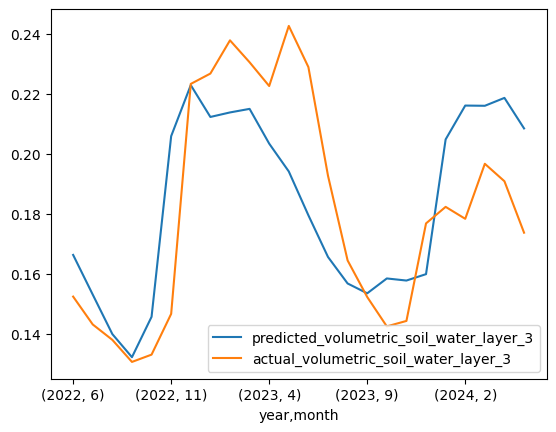

In [98]:
from tesi.zappai.utils.common import get_next_n_months

# GENERATE DATA
seed_data = df_test[(-MONTHS_BEFORE - SEQ_LENGTH) : -MONTHS_BEFORE]
start_year, start_month = seed_data.index[-1]

start_year, start_month = get_next_n_months(n=1, month=start_month, year=start_year)
year_to, month_to = get_next_n_months(n=24, month=start_month, year=start_year)

print(f"start_year: {start_year}")
print(f"start_month: {start_month}")

future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    (
        await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
            longitude=location.longitude,
            latitude=location.latitude,
            year_from=start_year,
            month_from=start_month,
            year_to=year_to,
            month_to=month_to,
        )
    )
)

# this generated data start from one year ago
generated_data_df = climate_generative_model_repository.generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data_df=seed_data,
    future_climate_data_df=future_climate_data_df,
)

predicted_kelvin_to_celsius = ["soil_temperature_level_3", "2m_dewpoint_temperature"]

for predicted_variable in TARGET:
    generated_data_df = generated_data_df[:24]
    generated_data_df[f"actual_{predicted_variable}"] = true_data_df[
        f"era5_{predicted_variable}"
    ]

    generated_data_df = generated_data_df.rename(
        columns={predicted_variable: f"predicted_{predicted_variable}"}
    )

for temperature in predicted_kelvin_to_celsius:
    if temperature in generated_data_df.columns:
        generated_data_df[f"predicted_{temperature}"] = (
            generated_data_df[f"predicted_{temperature}"] - 273.15
        )
        generated_data_df[f"actual_{temperature}"] = (
            generated_data_df[f"actual_{temperature}"] - 273.15
        )

for predicted_variable in TARGET:
    generated_data_df[
        [
            f"predicted_{predicted_variable}",
            f"actual_{predicted_variable}",
        ]
    ].plot()